# Models Pipeline

We want to see how different models affect our dataset.

In [9]:
from preprocessing import load_dataset, split_dataset, grid_search, interactions
from utilities import plot_grid_results
import models

We define the generic parameters, to be used to split the dataset.

In [10]:
test_size = 0.2         # the ratio of the dataset we want to use as test set
stratify = True         # Whether we want the split to keep the same proportion between classes as the original dataset
k = 5                   # The number of folds for the stratified k fold 

First of all, we load the dataset and we split it into training and test set (to be used only in the end).

In [11]:
# first, we load the dataset
X, y = load_dataset('./data/data.pkl')
# then, we split it
X_tr, y_tr, X_te, y_te = split_dataset(X, y, test=test_size, stratify=stratify)
a = 0

Now, we can start to try the grid search with different models, to see how it behaves.

Notice we want to have high __*recall*__ for class 'MATCH' (that is, we want to detect as many MATCH samples as possible). For this reason, we put recall as main metric for our grid search.

## K-Nearest Neighbors

We run a grid search on the kNN model, trying values of k from 1 to 10. Since our data is highly dimensional, we expect such an algorithm to perform bad.

In [12]:
# get pipeline 
pipe, grid = models.scaling(models.knn)
# call grid_search
out_knn = grid_search(X_tr, y_tr, pipe, grid, k)

print("Best model (according to recall): " + str(out_knn['best_params']))
print('-----------------------------------------')
print("Recall : " + str(out_knn['best_recall']))
print("Balanced accuracy: " + str(out_knn['best_balanced_accuracy']))
print("f1: " + str(out_knn['best_f1']))


Best model (according to recall): {'model__n_neighbors': 1}
-----------------------------------------
Recall : 0.23756337824134435
Balanced accuracy: 0.5497079057611745
f1: 0.2380105675331415


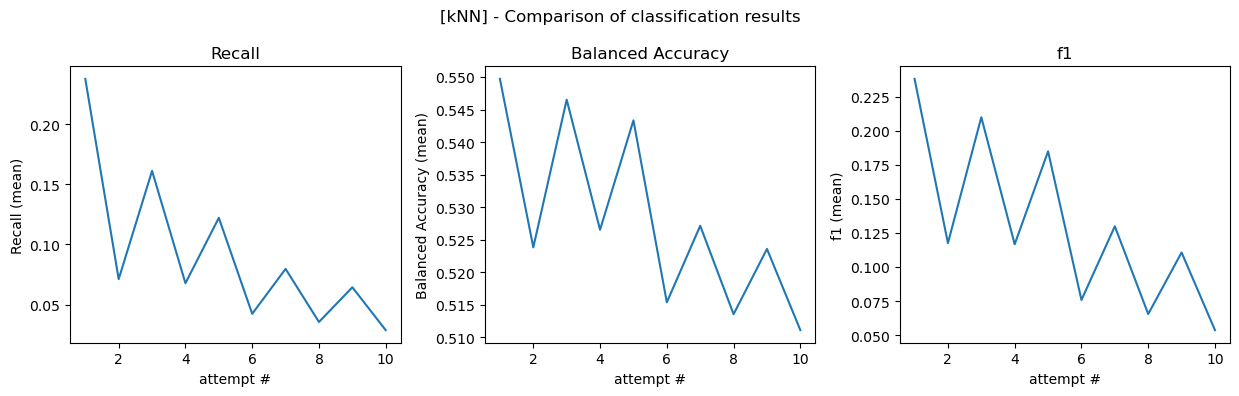

In [13]:
# Plot recall, balanced accuracy and f1 metric for every k in the range
plot_grid_results(out_knn, 'kNN')

As expected, we get a really low performance. ...

## Logistic Regression

Normal Logistic Regression does not converge. We try some strategies to reduce the dimensionality of our data.

### 1. LR - with interation, drop, scaling



In [14]:
X_tr_drop = interactions(X_tr, drop=True)

# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
out_lr_drop = grid_search(X_tr_drop, y_tr, pipe, grid, k)

print("Best model (according to recall): " + str(out_lr_drop['best_params']))
print('-----------------------------------------')
print("Recall : " + str(out_lr_drop['best_recall']))
print("Balanced accuracy: " + str(out_lr_drop['best_balanced_accuracy']))
print("f1: " + str(out_lr_drop['best_f1']))

Best model (according to recall): {'model__C': 10}
-----------------------------------------
Recall : 0.022048384760249166
Balanced accuracy: 0.508198446697236
f1: 0.04162024178691316


### 2. LR - with interation, drop, PCA

In [16]:
X_tr_int = interactions(X_tr, drop=True)

# get pipeline 
pipe, grid = models.pca([20, 30, 58], models.logistic_regression)
# call grid_search
out_lr_pca = grid_search(X_tr_int, y_tr, pipe, grid, k)

print("Best model (according to recall): " + str(out_lr_pca['best_params']))
print('-----------------------------------------')
print("Recall : " + str(out_lr_pca['best_recall']))
print("Balanced accuracy: " + str(out_lr_pca['best_balanced_accuracy']))
print("f1: " + str(out_lr_pca['best_f1']))

Best model (according to recall): {'model__C': 10000, 'pca__n_components': 58}
-----------------------------------------
Recall : 0.020338983050847456
Balanced accuracy: 0.5071867599712636
f1: 0.038590568022259915
